# LSTM for Diplomacy Deception Detection

This notebook implements a Bi-Directional LSTM model to detect deception in Diplomacy game messages. 
Unlike previous approaches using TF-IDF, this model uses raw text sequences to capture context and word order.

## Steps:
1. Load Data (Final enriched parquet files)
2. Text Preprocessing (Tokenization, Padding)
3. Model Definition (Embedding -> Bi-LSTM -> Dense)
4. Training with Class Weights (to handle imbalance)
5. Evaluation

In [2]:
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
data_path = os.path.join(base_path, "data", "processed", "diplomacy")
model_dir = os.path.join(base_path, "models")
model_path = os.path.join(model_dir, 'lstm_diplomacy.h5')
results_file = os.path.join(base_path, "reports", "model_results_deceptency_lstm.csv")

os.makedirs(model_dir, exist_ok=True)
os.makedirs(os.path.dirname(results_file), exist_ok=True)

Data Path: c:\work environment\Projects\amazon-spam-review\data\processed\diplomacy


In [7]:
# Load Data
train_df = pd.read_parquet(os.path.join(data_path, "train_processed.parquet"))
val_df = pd.read_parquet(os.path.join(data_path, "val_processed.parquet"))
test_df = pd.read_parquet(os.path.join(data_path, "test_processed.parquet"))

print(f"Train shape: {train_df.shape}")
print(f"Val shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")

# Check class distribution
print("\nClass Distribution (Train):")
print(train_df['target'].value_counts(normalize=True))

Train shape: (13132, 13)
Val shape: (1416, 13)
Test shape: (2741, 13)

Class Distribution (Train):
target
0    0.954995
1    0.045005
Name: proportion, dtype: float64


In [8]:
# CHECK FOR EXISTING MODEL
from tensorflow import keras
model_path = os.path.join(model_dir, 'lstm_diplomacy.h5')
try:
    model = keras.models.load_model(model_path)
    print(f'Model loaded from {model_path}')
    print('Skipping training and proceeding to evaluation...')
    skip_training = True
except (OSError, IOError):
    print('No existing model found. Will train a new model.')
    skip_training = False

Model loaded from c:\work environment\Projects\amazon-spam-review\models\deceptency\lstm_diplomacy.h5
Skipping training and proceeding to evaluation...


## Preprocessing
We use `message_text` (raw text) instead of `cleaned_text` to preserve stopwords and structure.

In [ ]:
try:
    if os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path)
        print(f'Model bulundu ve {model_path} konumundan yüklendi.')
        skip_training = True
    else:
        print('Mevcut model bulunamadı. Yeni model eğitilecek.')
        skip_training = False
except Exception as e:
    print(f'Model yüklenirken hata oluştu: {e}. Yeni model eğitilecek.')
    skip_training = False

In [9]:
# Parameters
VOCAB_SIZE = 10000
MAX_LEN = 150
EMBEDDING_DIM = 100
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOK = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(train_df['message_text'])

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Sequences
train_sequences = tokenizer.texts_to_sequences(train_df['message_text'])
val_sequences = tokenizer.texts_to_sequences(val_df['message_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['message_text'])

# Padding
X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
X_val = pad_sequences(val_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)
X_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

y_train = train_df['target'].values
y_val = val_df['target'].values
y_test = test_df['target'].values

print(f"X_train shape: {X_train.shape}")

Found 8285 unique tokens.
X_train shape: (13132, 150)


## Class Weights
Since the dataset is imbalanced, we calculate class weights to penalize the model more for missing the minority class (Deception).

In [10]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

Class Weights: {0: np.float64(0.5235627142971055), 1: np.float64(11.109983079526227)}


## Model Definition
We use a Bidirectional LSTM to capture context from both past and future words in the sequence.

In [11]:
def build_model(vocab_size, embedding_dim, max_len):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

model = build_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN)
model.summary()

c:\Users\Aybars\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.0001)

In [13]:
if not skip_training:
    # Train
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    end_time = time.time()
    training_time_minutes = (end_time - start_time) / 60
    print(f"Training time: {training_time_minutes:.2f} minutes")

## Evaluation

NameError: name 'history' is not defined

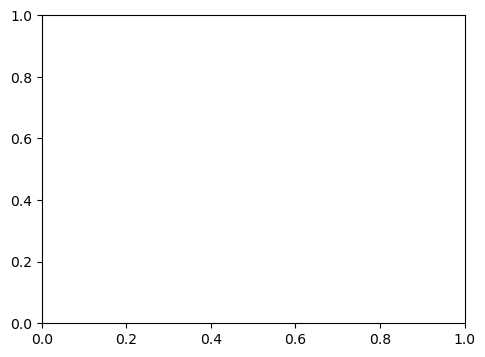

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
# Save model
if not skip_training:
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)
    print(f"Model saved to {model_path}")
else:
    print("Model was loaded, no need to save")

In [ ]:
# Save Results to CSV
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

report = classification_report(y_test, y_pred, output_dict=True)

result_data = {
    'category': 'Deceptency_LSTM',
    'best_cv_f1_score': 'N/A',
    'test_accuracy': report['accuracy'],
    'test_f1_truth': report['0']['f1-score'],
    'test_precision_truth': report['0']['precision'],
    'best_params': '{"epochs": 20, "batch_size": 32}',
    'training_time_minutes': training_time_minutes
}

results_file = os.path.join(base_path, "reports", "model_results_deceptency_lstm.csv")
result_df = pd.DataFrame([result_data])
header = not os.path.exists(results_file)
result_df.to_csv(results_file, mode='a', header=header, index=False)

print(f"Results saved to {results_file}")

Model saved.
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
Results saved to c:\work environment\Projects\amazon-spam-review\reports\model_results_deceptency_lstm.csv


In [ ]:
# Save Model
model.save(os.path.join(base_path, "models", "lstm_diplomacy.h5"))
print("Model saved.")

Model saved.


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix - Diplomacy Deception Detection')
plt.show()